# Navigation

---

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)
print(tf.__version__)
print(np.__version__)

import inspect

def get_var_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    name = [k for k, v in callers_local_vars if v is var]
    return name[0]

0.4.0
1.13.1
1.15.3


We first gonna load the gym from open ai gym to setup a simple benchmark study.

In [2]:
import gym

env = gym.make('LunarLander-v2')

seed = 0
env.seed(seed)
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

print('State shape: ', state_size)
print('Number of actions: ', action_size)

State shape:  8
Number of actions:  4


Episode 100	Average Score: -160.35
Episode 200	Average Score: -66.032
Episode 300	Average Score: -29.84
Episode 400	Average Score: 9.5419
Episode 500	Average Score: 36.23
Episode 100	Average Score: -175.61
Episode 200	Average Score: -69.580
Episode 300	Average Score: -17.68
Episode 400	Average Score: -28.91
Episode 500	Average Score: -4.004


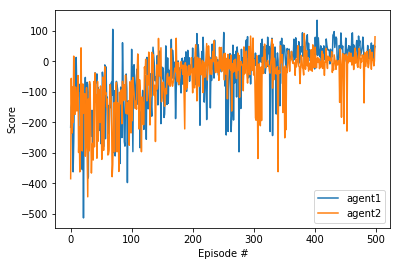

In [5]:
from models.dqn_agent import DQNAgent
from training.q_learning import dqn

agent1 = DQNAgent(state_size, action_size, seed, network_type='linear')
agent2 = DQNAgent(state_size, action_size, seed, network_type='linear')

n_episodes = 500
max_t = 200

scores1 = dqn(agent1, env, n_episodes, max_t)
scores2 = dqn(agent2, env, n_episodes, max_t)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores1)), scores1, label=get_var_name(agent1))
plt.plot(np.arange(len(scores2)), scores2, label=get_var_name(agent2))
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 2. Load the model

Here we select two models, a critrium to benchmark them and launch a dummmy training session. After, we plot the training results. 

### 3. Load the Unity environment and Take Random Actions in the Environment

Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
from unityagents import UnityEnvironment
from models.dqn_agent import DQNAgent

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86")
#env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

train_mode = False
action_size = brain.vector_action_space_size
env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
state = env_info.vector_observations[0]
state_size = len(state)

state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for t in range(10):
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Score: 0.0


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The observations are in a 37-dimensional continuous space corresponding to 35 dimensions of ray-based perception of objects around the agent’s forward direction and 2 dimensions of velocity. The 35 dimensions of ray perception are broken down as: 7 rays projecting from the agent at the following angles (and returned back in the same order): [20, 90, 160, 45, 135, 70, 110] where 90 is directly in front of the agent. Each ray is 5 dimensional and it projected onto the scene. If it encounters one of four detectable objects (i.e. yellow banana, wall, blue banana, agent), the value at that position in the array is set to 1. Finally there is a distance measure which is a fraction of the ray length. Each ray is [Yellow Banana, Wall, Blue Banana, Agent, Distance]. For example, [0,1,1,0,0,0.2] means that there is a blue banana detected 20% of the distance along the ray with a wall behind it. The velocity of the agent is two dimensional: left/right velocity (usually near 0) and forward/backward velocity (0 to 11.2).

### 4. Train

The simplest baseline is a Q-learning agent

#### Vanilla DQN

In [3]:
from unityagents import UnityEnvironment
from models.dqn_agent import DQNAgent
from training.q_learning import dqn_unity

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86")
seed=0
#env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

train_mode = True
action_size = brain.vector_action_space_size
env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
state = env_info.vector_observations[0]
state_size = len(state)

# load model
agent3 = DQNAgent(state_size, action_size, seed, network_type='linear')

# start training             
scores3 = dqn_unity(agent3, env, brain_name, env_info, n_episodes=1000, max_t=200, eps_start=1.0, eps_end=0.01, eps_decay=0.995)
print("Score: {}".format(scores3))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.53
Episode 200	Average Score: 2.80
Episode 300	Average Score: 4.81
Episode 400	Average Score: 6.71
Episode 500	Average Score: 7.39
Episode 600	Average Score: 8.28
Episode 700	Average Score: 8.89
Episode 800	Average Score: 10.27
Episode 900	Average Score: 9.881
Episode 1000	Average Score: 10.08
Score: [0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 1.0, 1.0, 0.0, -2.0, 0.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 0.0, -1.0, 3.0, 0.0, -1.0, 0.0, 2.0, -1.0, -1.0, 1.0, -1.0, -2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 2.0, 0.0, -1.0, 2.0, 1.0, -1.0, 1.0, 2.0, -1.0, -1.0, 1.0, 0.0, 0.0, 3.0, 2.0, 1.0, 2.0, -2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 0.0, 1.0, 1.0, -2.0, 2.0, -1.0, 2.0, 2.0, 2.0, 0.0, 2.0, 3.0, 2.0, 0.0, -1.0, 0.0, 2.0, 1.0, 4.0, 0.0, -1.0, 2.0, 3.0, 1.0, 0.0, 1.0, -1.0, -2.0, 5.0, 2.0, 3.0, 2.0, 1.0, 4.0, 2.0, 3.0, 1.0, 2.0, 3.0, 3.0, 2.0, -2.0, 2.0, 1.0, 4.0, 5.0, 1.0, 4.0, 5.0, 2.0, 4.0, 2.0, 1.0, 2.0, 0.0, 2.0, 5.0, 1.0, 6.0, 3.0, 2.0, 6.

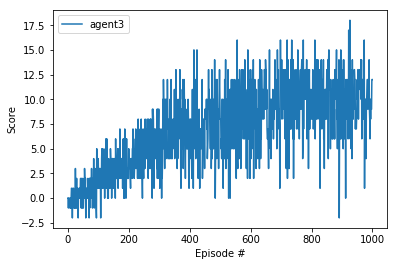

In [4]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores3)), scores3, label=get_var_name(agent3))
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Double DQN

In [3]:
from unityagents import UnityEnvironment
from models.dqn_agent import DQNAgent
from training.q_learning import dqn_unity

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86")
seed=0
#env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

train_mode = True
action_size = brain.vector_action_space_size
env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
state = env_info.vector_observations[0]
state_size = len(state)

# load model
agent4 = DQNAgent(state_size, action_size, seed, network_type='linear', config='double')

# start training             
scores4 = dqn_unity(agent4, env, brain_name, env_info, n_episodes=1000, max_t=200, eps_start=1.0, eps_end=0.01, eps_decay=0.995)
print("Score: {}".format(scores4))
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: -0.12
Episode 200	Average Score: -0.04
Episode 300	Average Score: 0.051
Episode 400	Average Score: 0.13
Episode 500	Average Score: 0.18
Episode 600	Average Score: 0.191
Episode 700	Average Score: 0.30
Episode 800	Average Score: 0.62
Episode 900	Average Score: 0.17
Episode 1000	Average Score: 0.22
Score: [0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 1.0, 2.0, -1.0, -2.0, 1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, -3.0, 0.0, -1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -2.0, 1.0, -2.0, -1.0, 0.0, -2.0, 0.0, 0.0, 0.0, 0.0, 1.0, -2.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 1.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -2.0, 2.0, 1.0, -2.0, -1.0, 0.0, -2.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -2.0, 0.0, 0.0, 0.0, -2.0, 1.0, 0.0, 0.0, -2.0, 2.0, 0.0, -1.0, 2.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0,

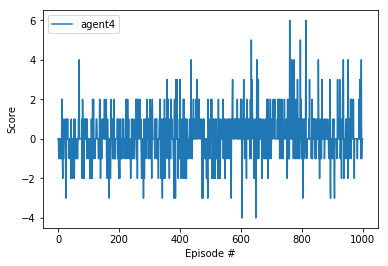

In [4]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores4)), scores4, label=get_var_name(agent4))
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()